In [1]:
import numpy as np
import os 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt


import pickle

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
ARTIFACTS_PATH = "../artifacts"

In [3]:
VOCAB_SIZE = 5000 
MAX_LEN = 200
NUM_CLASSES = 5

In [4]:
def load_padded_sequences():
    X_train_pad = np.load(os.path.join(ARTIFACTS_PATH, "X_train_pad.npy"))
    X_test_pad = np.load(os.path.join(ARTIFACTS_PATH, "X_test_pad.npy"))

    return X_train_pad, X_test_pad


def load_labels():
    y_train = np.load(os.path.join(ARTIFACTS_PATH, "y_train.npy"))
    y_test = np.load(os.path.join(ARTIFACTS_PATH, "y_test.npy"))

    return y_train, y_test



X_train_pad , X_test_pad = load_padded_sequences()
y_train, y_test = load_labels()


In [5]:
with open("/Users/sarthaksharna/AutoNews/artifacts/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

In [6]:
def create_tuned_model():

    model = Sequential([
        Input(shape=(MAX_LEN,)),
        Embedding(input_dim=VOCAB_SIZE, output_dim=128, mask_zero=True),
        LSTM(128),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation="softmax")

    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [7]:
model = create_tuned_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 772,229 (2.95 MB)

 Trainable params: 772,229 (2.95 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
early_stop = EarlyStopping(monitor="val_loss", patience = 5, restore_best_weights = True)

In [9]:
history = model.fit(
    X_train_pad,
    y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - accuracy: 0.2676 - loss: 1.5900 - val_accuracy: 0.3196 - val_loss: 1.5753
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.4243 - loss: 1.4140 - val_accuracy: 0.4340 - val_loss: 1.2774
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.5250 - loss: 1.1212 - val_accuracy: 0.5806 - val_loss: 1.1407
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - accuracy: 0.6882 - loss: 0.8297 - val_accuracy: 0.6188 - val_loss: 0.9922
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.8331 - loss: 0.7048 - val_accuracy: 0.8006 - val_loss: 0.6701
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.9074 - loss: 0.3457 - val_accuracy: 0.7625 - val_loss: 0.7668
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.8331 - loss: 0.4829 - val_accuracy: 0.6569 - val_loss: 0.9294
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9140 - loss: 0.3381 - val_accuracy: 0.

In [10]:
test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9085 - loss: 0.3509
Test Accuracy: 0.9085
Test Loss: 0.3509


In [11]:
def evaluate_model_simple(model, X_test, y_test, label_encoder):
    # Keras evaluation
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Predictions
    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

    # Confusion Matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_classes))


evaluate_model_simple(model, X_test_pad, y_test, le)



Test Loss: 0.3509
Test Accuracy: 0.9085
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

Classification Report:
               precision    recall  f1-score   support

     business       0.94      0.90      0.92       101
entertainment       0.95      0.77      0.85        74
     politics       0.88      0.91      0.90        81
        sport       0.91      0.98      0.94       101
         tech       0.87      0.96      0.91        69

     accuracy                           0.91       426
    macro avg       0.91      0.90      0.90       426
 weighted avg       0.91      0.91      0.91       426


Confusion Matrix:
[[91  1  4  2  3]
 [ 3 57  5  5  4]
 [ 2  0 74  2  3]
 [ 0  2  0 99  0]
 [ 1  0  1  1 66]]


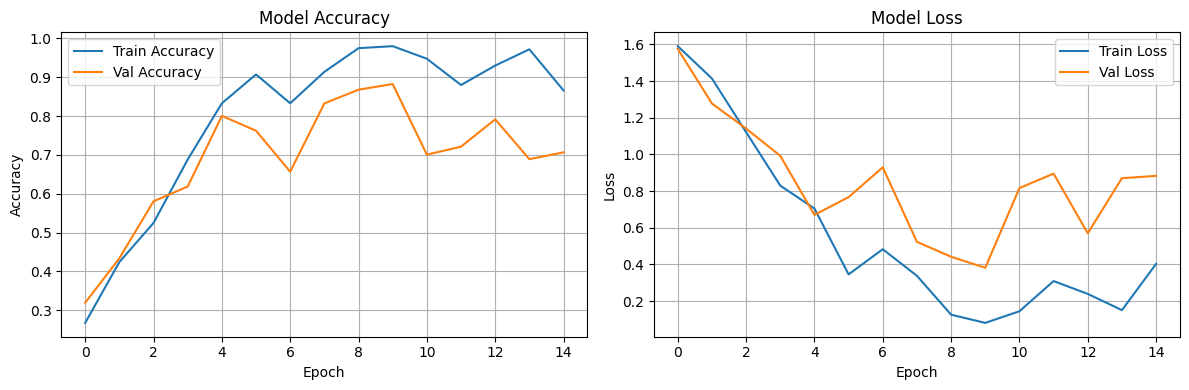

In [12]:
# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()